# In case, the file import data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd /content/drive/MyDrive/Colab\ Notebooks/Thesis/
# %cd Mydrive/

%cd drive/MyDrive/Colab\ Notebooks/Thesis_st121166
# !ls

/content/drive/MyDrive/Colab Notebooks/Thesis_st121166


In [ ]:
# Install libraries
!pip install mne
!pip install PyWavelets
# !pip install pyriemann

     |████████████████████████████████| 7.4 MB 4.5 MB/s 


## Reference paper
- Paper "Comparative Study of Wavelet-Based Unsupervised Ocular Artifact Removal Techniques for Single-Channel EEG Data"

## Reference for the data
- https://data.mendeley.com/datasets/wb6yvr725d/4

    - EEG electrodes (Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, T6, Fz, Cz, Pz) were placed according to the 10–20 International System,
    - Sampling frequency = 200 Hz
    - Bandpass filter at 0.5-40Hz
    - Notch filter at 50 Hz
    - Each dataset has 30 seconds duration
    - OAs occur due to eye moment and eye-blinks and have freuqncy ranges of 0-7 Hz and 8-13 Hz

## Select 1st dataset (54 subjects * each has 19 EEG channels + 2 EOG channels)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.io
import scipy.signal
import seaborn as sns; sns.set_style("darkgrid") # styling
import pywt

def createSubplot(n):
    fig,axs = plt.subplots(n,figsize=(15,8))
    fig.tight_layout(pad=3.0)
    return fig,axs

number_subjects = 54
initial_fs = 200
EEG_electrodes = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 
                  'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

initial_pure_dataset = scipy.io.loadmat("Datasets/semi_EEG-EOG/Pure_Data.mat")
initial_cont_dataset = scipy.io.loadmat("Datasets/semi_EEG-EOG/Contaminated_Data.mat")
initial_HEOG = scipy.io.loadmat("Datasets/semi_EEG-EOG/HEOG.mat")
initial_VEOG =scipy.io.loadmat("Datasets/semi_EEG-EOG/VEOG.mat")

In [ ]:
def createSubplot(n):
    fig,axs = plt.subplots(n,figsize=(15,8))
    fig.tight_layout(pad=3.0)
    return fig,axs

### Calculte FFT
def next_pow2(x):
    return 1<<(x-1).bit_length()

def calculate_FFT(inputSignal, fs, n_zeropad=0, window="False", timescaling=1):
    
    my_signal = inputSignal.copy()
    
    if window != "False":
        window = get_window(window, inputSignal.shape[0])
        my_signal *= window # multiply signal by window to reduce fluctuation in frequency-domain
        
    time_zeropadding =  np.hstack((my_signal, np.zeros(int(n_zeropad)))) # zero-padding in time-domain
    nfft = time_zeropadding.shape[0]           # get the number of samples in the signal
#     nfft = next_pow2(nfft)                                     # FFT is more efficient when using number of samples is part of power of 2
    fft = np.fft.fft(my_signal,nfft)[:int(np.ceil(nfft/2))]             # extract only the 1st half of the result (one-side frequency
    fft = fft*2                                                # multiply magnitude by 2 after select only one-side frequency
    corr_mag_fft = np.abs(fft)/nfft * (nfft / my_signal.shape[0]) / timescaling

    df = fs/nfft                                   # finding frequency resolution
    xfft = np.arange(0, fs/2,df)                   # correcting x-axis
    
    return xfft, corr_mag_fft

def grab_children(father):
    nestedDict_to_lists = []
    for key, value in father.items():
        if type(value) == dict:
            nestedDict_to_lists.append(grab_children(value))
        else:
            nestedDict_to_lists.append(value)
    return nestedDict_to_lists

In [ ]:
def ExtractOnlyEEG(dict_inputEEG):
    outputEEG = dict()
    for key, value in dict_inputEEG.items():
        if key not in ['__header__', '__version__', '__globals__']:
            outputEEG[key] = value
    return outputEEG

extracted_pure_eeg = ExtractOnlyEEG(initial_pure_dataset)
extracted_cont_eeg = ExtractOnlyEEG(initial_cont_dataset)

def findMinumumEEGLength(dict_inputEEG):
    minEEGLength = int()
    for idx, eeg_values in enumerate(dict_inputEEG.values()):
        EEGLength = eeg_values.shape[-1]
        if idx == 0:
            minEEGLength = EEGLength
        elif minEEGLength > EEGLength:
            minEEGLength = EEGLength
    return minEEGLength

minEEGLength = findMinumumEEGLength(extracted_cont_eeg)
print(f"Minumum EEG length: {minEEGLength}")

# sampling frequency = 200 Hz and 26 seconds
selectedEEGLength = 200 * 26
print(f"Selected EEG length: {selectedEEGLength}")

Minumum EEG length: 5401
Selected EEG length: 5200


In [ ]:
def SelectLengthChannel(dict_inputEEG, selectEEGLength):
    """
    selectEEGChannel get an index according to the data's channels information like Fp1 = '0'
    """
    dict_oneChannelEEG = dict()
    for key, value in dict_inputEEG.items():
        dict_oneChannelEEG[key] = value[:, :selectEEGLength]
    return dict_oneChannelEEG

selectedLength_pureEEG = SelectLengthChannel(dict_inputEEG=extracted_pure_eeg,
                                              selectEEGLength=selectedEEGLength)
selectedLength_contEEG = SelectLengthChannel(dict_inputEEG=extracted_cont_eeg,
                                              selectEEGLength=selectedEEGLength)

print(f"Number of subjects: {len(list(extracted_pure_eeg.keys()))}")
print(f"The number of samples of contaminated EEG in one subject: {selectedLength_contEEG['sim1_con'].shape}")

Number of subjects: 54
The number of samples of contaminated EEG in one subject: (19, 5200)


In [ ]:
selectedLength_pureEEG['sim1_resampled']

array([[ 11.333812  ,  12.3151865 ,  10.298577  , ...,  18.416552  ,
         10.603204  ,  -0.49050134],
       [-13.910137  , -25.642948  , -25.847677  , ...,  -2.608148  ,
        -10.203584  , -20.998623  ],
       [ 13.081046  ,  14.299351  ,  12.183936  , ...,  17.051987  ,
         11.164237  ,   2.2971752 ],
       ...,
       [  4.4241457 ,   3.7565234 ,   2.471671  , ...,   4.1265397 ,
          1.062584  ,  -4.277618  ],
       [  6.063719  ,   6.5755897 ,   5.641155  , ...,   4.728157  ,
          2.9452708 ,  -0.5077277 ],
       [  9.5622015 ,   6.000428  ,  -0.6029951 , ...,   9.93274   ,
         15.28086   ,  17.110352  ]], dtype=float32)

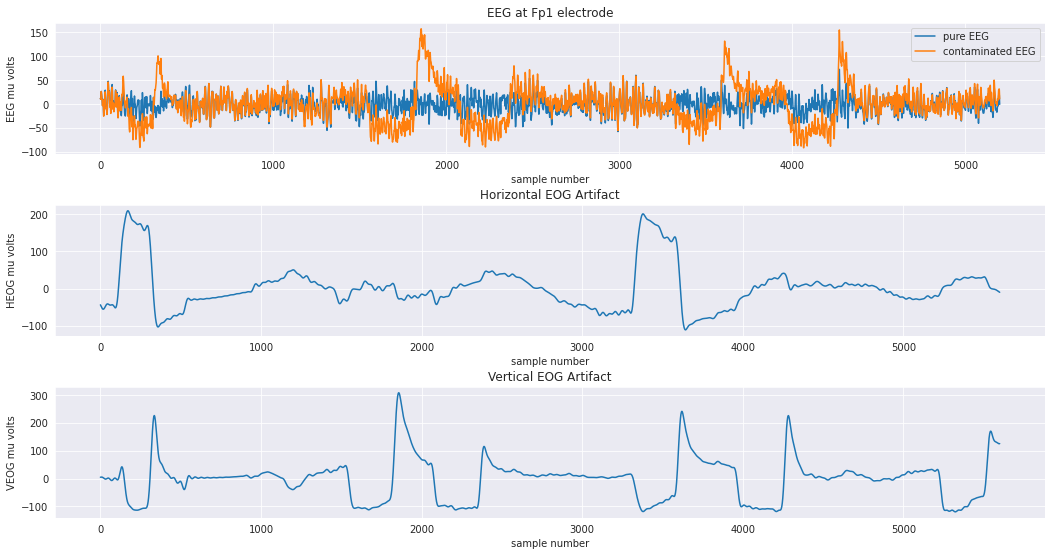

In [ ]:
index_selected_electrode = 0

# Plot pure EEG, contaminated EEG of selected electrode, HEOG, VEOG
fig, axs = createSubplot(3)

plt.sca(axs[0])
plt.plot(selectedLength_pureEEG["sim1_resampled"][index_selected_electrode], label="pure EEG") 
plt.plot(selectedLength_contEEG["sim1_con"][index_selected_electrode], label="contaminated EEG") 
plt.xlabel("sample number")
plt.ylabel("EEG mu volts")
plt.title(f"EEG at {EEG_electrodes[index_selected_electrode]} electrode")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(initial_HEOG["heog_1"][0])
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[2])
plt.plot(initial_VEOG["veog_1"][0])
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.show()

### Decomposition by DWT

From the input signal's sampling frequency was **200 Hz** and OAs occur due to eye moment and eye-blinks and have freuqncy ranges of 0-7 Hz and 8-13 Hz

- level 01: 50-100 Hz cD1
- level 02: 25-50 Hz cD2
- level 03: 12.5-25 Hz cD3
- level 04: 6.25-12.5 Hz cD4
- level 05: 3.125-6.25 Hz cD5
- level 06: 1.5625-3.125 Hz cD6
- level 07: 0.78125-1.5625 Hz cD7
- level 08: 0.390625-0.78125 Hz cD8
- level 09: 0-0.390625 cA8


In [ ]:
# # Determine a setting for wavelet decomposition
# initial_fs = 200
# index_selected_electrode = 0
# pure_EEG_s001_Fz = initial_pure_eeg["sim1_resampled"][index_selected_electrode]
# cont_EEG_s001_Fz = initial_cont_eeg["sim1_con"][index_selected_electrode]

# dec_level = 8
# wavelet = "bior4.4"

# start_frequency = 0
# end_frequency = (initial_fs / (2**(dec_level + 1)))
# coeffs = pywt.wavedec(pure_EEG_s001_Fz, wavelet, level=dec_level)
# approx = coeffs[0]
# details = coeffs[1:]

# for ix, coeff in enumerate(coeffs):
#     if ix != 0:
#         print(f"cD{dec_level-ix+1} has shape: {coeff.shape} and responds for frequency band: {start_frequency}-{end_frequency}")
#         start_frequency = end_frequency
#         end_frequency = end_frequency * 2  
#     else:
#         print(f"cA{dec_level} has shape: {coeff.shape} and responds for frequency band: {start_frequency}-{end_frequency}")
#         start_frequency = end_frequency
#         end_frequency = end_frequency * 2

In [ ]:
# Method for finding threshold, 'Thresholding selection rule'
def sqtwolog_threshold(wavelet_coeffs):
    """
    Universal thresholding
    """
    denom = scipy.stats.norm.ppf(0.75) # the constant value for Gaussian noise (0.6745)
    var = np.median(np.abs(wavelet_coeffs)) / denom
    N = len(wavelet_coeffs)
    thre = np.sqrt(var) * np.sqrt(2 * np.log(N))
    return thre

def rigsure_threshold(wavelet_coeffs):
    var = np.std(wavelet_coeffs)
    N = len(wavelet_coeffs)
    sqr_coeffs = []
    for coeff in wavelet_coeffs:
        sqr_coeffs.append(np.power(coeff, 2))
    sqr_coeffs.sort()
    pos = 0
    r = 0
    for idx, sqr_coeff in enumerate(sqr_coeffs):
        new_r = (N - 2 * (idx + 1) + (N - (idx + 1))*sqr_coeff + sum(sqr_coeffs[0:idx+1])) / N
        if r == 0 or r > new_r:
            r = new_r
            pos = idx
    thre = np.sqrt(var) * np.sqrt(sqr_coeffs[pos])
    return thre

def heursure_threshold(wavelet_coeffs):
    N = len(wavelet_coeffs)
    s = 0
    for coeff in wavelet_coeffs:
        s += np.power(coeff, 2)
    theta = (s - N) / N
    # It is divide by ...
    miu = np.power(np.log2(N), 3/2) / np.power(N, 1/2)
    if theta < miu:
        return sqtwolog_threshold(wavelet_coeffs)
    else:
        return min(sqtwolog_threshold(wavelet_coeffs), rigsure_threshold(wavelet_coeffs))
    
def statistical_threshold(wavelet_coeffs):
    """
    Put wavelet coefficients of one level to the function
    Return the statistical threshold value of that level
    """
    threshold_value = 1.5 * np.std(wavelet_coeffs)
    return threshold_value

#### 3.1 DWT + heursure threshold (Fp1 electrode)

In [ ]:
# index_selected_electrode = -3
# pure_EEG_sample = selectedLength_pureEEG["sim1_resampled"][index_selected_electrode]
# cont_EEG_sample = selectedLength_contEEG["sim1_con"][index_selected_electrode]
# HEOG_sample = initial_HEOG["heog_1"][0]
# VEOG_sample = initial_VEOG["veog_1"][0]
# noisy_size = cont_EEG_sample.size

# wavelet = 'bior3.9'
# dec_level = 8
# coeffs = pywt.wavedec(cont_EEG_sample, wavelet=wavelet, level=dec_level)

# # for onelvlCoeffs in coeffs:
# #     for eachCoeff in onelvlCoeffs:
# #         print(eachCoeff)

In [ ]:
# index_selected_electrode = 0
# pure_EEG_sample = selectedLength_pureEEG["sim1_resampled"][index_selected_electrode]
# cont_EEG_sample = selectedLength_contEEG["sim1_con"][index_selected_electrode]
# HEOG_sample = initial_HEOG["heog_1"][0]
# VEOG_sample = initial_VEOG["veog_1"][0]
# noisy_size = cont_EEG_sample.size

# wavelet = 'bior3.9'
# dec_level = 8
# coeffs = pywt.wavedec(cont_EEG_sample, wavelet=wavelet, level=dec_level)

# for onelvlCoeffs in coeffs:
#     print(onelvlCoeffs.shape)
# #     for eachCoeff in onelvlCoeffs:
# #         print(eachCoeff)

In [ ]:
# denoised_coeffs = [] # Prepare for contain denoise coefficients

# for ix, coeff in enumerate(coeffs):
#     # thresholding has been done over the cD from level 8 up to level 3 (Cover OAs freq. band/related coefficients)
#     threshold_value = None
#     if ix in range(1,5):
#         # threshold value in each level is calculated by universal_threshold (noise estimation)
#         threshold_value = statistical_threshold(wavelet_coeffs=coeff)

#         # According to the paper
#         # wavelet coefficient (wc) is removed if np.abs(wc) > threshold value
#         denoised_coeff = np.where(np.abs(coeff) > threshold_value, 0, coeff)
#         denoised_coeffs.append(denoised_coeff)

#     else:
#         denoised_coeffs.append(coeff)  
        
# denoised_EEG = pywt.waverec(denoised_coeffs, wavelet=wavelet)
# SAR = calculate_SAR(cont_EEG_sample, denoised_EEG[:-1])
# print(f"Signal to Artifact ratio (SAR): {SAR}")

In [ ]:
EEG_electrodes = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 
                  'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

In [ ]:
def denoised_with_DiscreteWavelet(oneCH_EEG, 
                                  motherWavelet="bior3.9", decLevel=8, 
                                  thresholdSelectionRule="statistical_threshold", thresholdingFunction="hard",
                                  lcoeffLevel=1, rcoeffLevel=5):
    """
    contEEG is a dataset containing contaminated EEG (54 subjects each has 19 EEG channels)
    motherWavelet = 'bior3.9' (Paper)
    decLevel = 8 (Calculate)
    thresholdSelectionRule = "heursure_threshold" or "statistical_threshold"
    thresholdingFunction = "soft" or "hard" thresholding
    lcoeffLevel = the coefficients corresponding to lower frequency bands that we want to threshold/denoise
    rcoeffLevel = the coefficients corresponding to upper frequency bands that we want to threshold/denoise
    """
    
    denoised_coeffs = [] # Prepare for contain denoise coefficients
    coeffs = pywt.wavedec(oneCH_EEG, wavelet=motherWavelet, level=decLevel)
    for ix, coeff in enumerate(coeffs):
        # thresholding has been done over the cD from level 8 up to level 3 (Cover OAs freq. band/related coefficients)
        threshold_value = None
        if ix in range(lcoeffLevel,rcoeffLevel):
            if thresholdSelectionRule == "statistical_threshold":
                threshold_value = statistical_threshold(wavelet_coeffs=coeff)
            else:
                threshold_value = heursure_threshold(wavelet_coeffs=coeff)

            # According to the paper
            # wavelet coefficient (wc) is removed if np.abs(wc) > threshold value
            denoised_coeff = np.where(np.abs(coeff) > threshold_value, 0, coeff)
            denoised_coeffs.append(denoised_coeff)

        else:
            denoised_coeffs.append(coeff)  
        
    denoised_oneCH_EEG = pywt.waverec(denoised_coeffs, wavelet=motherWavelet)
    return denoised_oneCH_EEG

In [ ]:
selectedLength_denoisedEEG = {}
for subjectID, manyCH_contEEG in selectedLength_contEEG.items():
    manyCH_denoisedEEG = []
    for idx_EEGch, oneCH_contEEG in enumerate(manyCH_contEEG):
#         # Change the length of each subject's EEG to the same length
#         oneCH_contEEG = oneCH_contEEG[:selectedEEGLength]
#         print(oneCH_EEG.shape)
        # Denoise every electrode
        if idx_EEGch in range(len(EEG_electrodes)):
            oneCH_denoisedEEG = denoised_with_DiscreteWavelet(oneCH_contEEG, 
                                    motherWavelet="bior3.9", decLevel=8, 
                                    thresholdSelectionRule="statistical_threshold", thresholdingFunction="hard",
                                    lcoeffLevel=1, rcoeffLevel=5)
            
            manyCH_denoisedEEG.append(oneCH_denoisedEEG)
    selectedLength_denoisedEEG[subjectID] = np.array(manyCH_denoisedEEG)

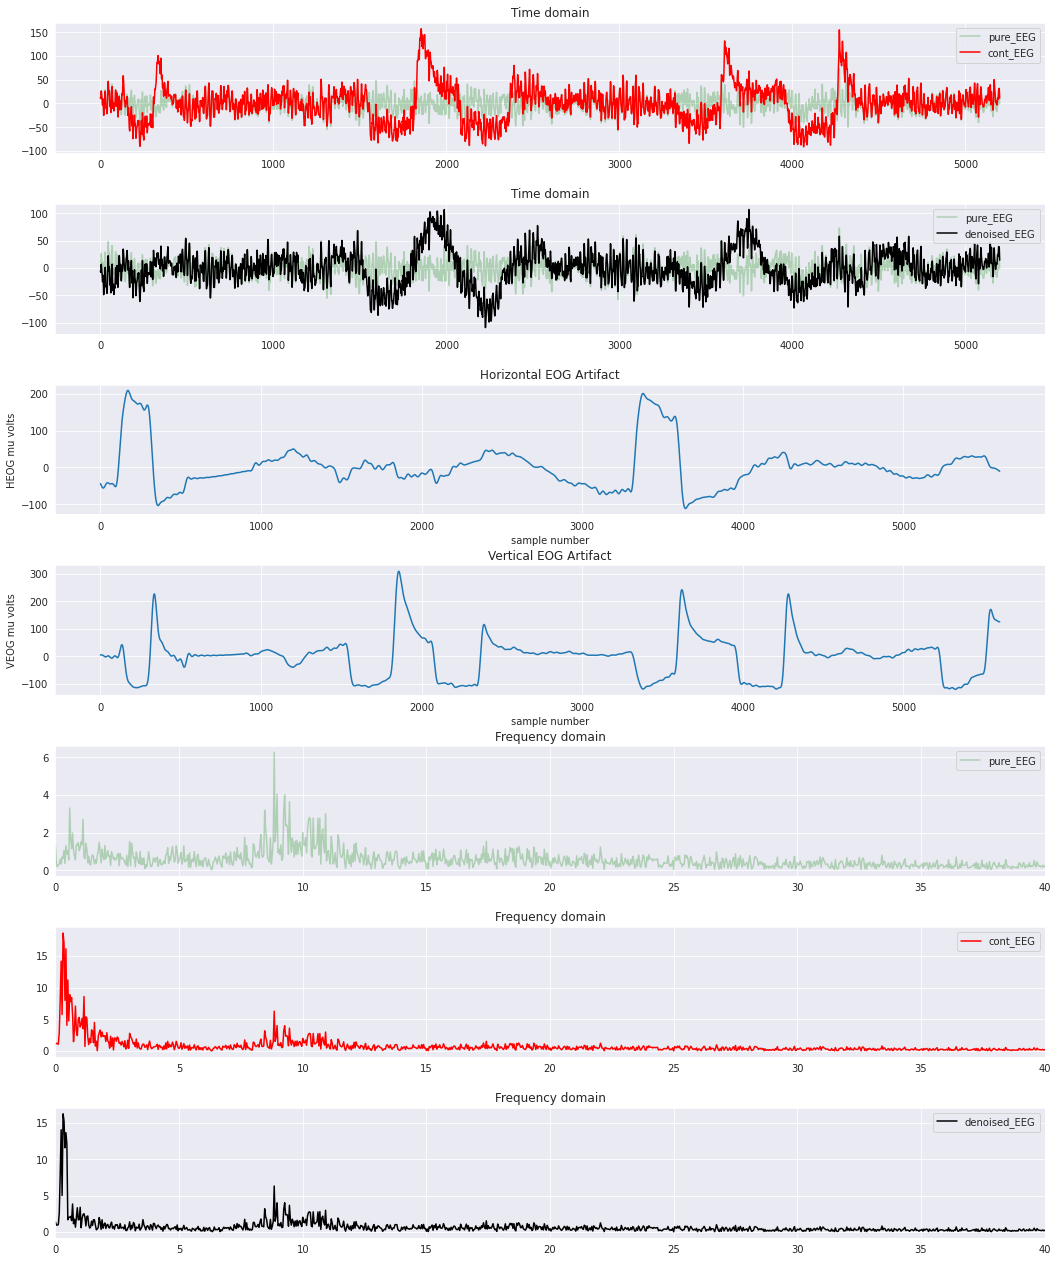

In [ ]:
def createSubplot(n):
    fig,axs = plt.subplots(n,figsize=(15,18))
    fig.tight_layout(pad=3.0)
    return fig,axs

# Prepare subplots
fig, axs = createSubplot(7)

pure_EEG_sample = selectedLength_pureEEG["sim1_resampled"][0]
cont_EEG_sample = selectedLength_contEEG["sim1_con"][0]
denoised_EEG_sample = selectedLength_denoisedEEG["sim1_con"][0]
HEOG_sample = initial_HEOG["heog_1"][0]
VEOG_sample = initial_VEOG["veog_1"][0]

plt.sca(axs[0])
plt.plot(pure_EEG_sample, label="pure_EEG", color="g", alpha=0.25)
plt.plot(cont_EEG_sample, label="cont_EEG", color="r")
plt.title("Time domain")
plt.legend(loc="upper right")

plt.sca(axs[1])
plt.plot(pure_EEG_sample, label="pure_EEG", color="g", alpha=0.25)
plt.plot(denoised_EEG_sample, label="denoised_EEG", color="k")
plt.title("Time domain")
plt.legend(loc="upper right")


plt.sca(axs[2])
plt.plot(HEOG_sample) # the 1st HEOG sample's Fz electrode
plt.xlabel("sample number")
plt.ylabel("HEOG mu volts")
plt.title("Horizontal EOG Artifact")

plt.sca(axs[3])
plt.plot(VEOG_sample) # the 1st VEOG sample's Fz electrode
plt.xlabel("sample number")
plt.ylabel("VEOG mu volts")
plt.title("Vertical EOG Artifact")

plt.sca(axs[4])
# Signal's frequency sampling = 200
xfft_pure_EEG, corr_mag_fft_pure_EEG = calculate_FFT(pure_EEG_sample, fs=200)
plt.plot(xfft_pure_EEG, corr_mag_fft_pure_EEG, label="pure_EEG", color="g", alpha=0.25)
plt.title("Frequency domain")
plt.legend(loc="upper right")
plt.xlim(0,40)

plt.sca(axs[5])
xfft_cont_EEG, corr_mag_fft_cont_EEG = calculate_FFT(cont_EEG_sample, fs=200)
plt.plot(xfft_cont_EEG, corr_mag_fft_cont_EEG, label="cont_EEG", color="r")
plt.title("Frequency domain")
plt.legend(loc="upper right")
plt.xlim(0,40)

plt.sca(axs[6])
xfft_cont_EEG, corr_mag_fft_cont_EEG = calculate_FFT(denoised_EEG_sample, fs=200)
plt.plot(xfft_cont_EEG, corr_mag_fft_cont_EEG, label="denoised_EEG", color="k")
plt.title("Frequency domain")
plt.legend(loc="upper right")
plt.xlim(0,40)

plt.show()

In [ ]:
# selectedLength_denoisedEEG = {}
# dict_SAR = {}
# for subjectID, manyCH_contEEG in selectedLength_contEEG.items():
#     manyCH_denoisedEEG = []
#     manyCH_SAR= []
#     for idx_EEGch, oneCH_contEEG in enumerate(manyCH_contEEG):
# #         # Change the length of each subject's EEG to the same length
# #         oneCH_contEEG = oneCH_contEEG[:selectedEEGLength]
# #         print(oneCH_EEG.shape)
#         # Denoise every electrode
#         if idx_EEGch in range(len(EEG_electrodes)):
#             oneCH_denoisedEEG = denoised_with_DiscreteWavelet(oneCH_contEEG, 
#                                     motherWavelet="bior3.9", decLevel=8, 
#                                     thresholdSelectionRule="statistical_threshold", thresholdingFunction="hard",
#                                     lcoeffLevel=1, rcoeffLevel=5)
#             oneCH_SAR = calculate_SAR(noisy_EEG=oneCH_contEEG, 
#                                       denoised_EEG=oneCH_denoisedEEG)
            
#             manyCH_denoisedEEG.append(oneCH_denoisedEEG)
#             manyCH_SAR.append(oneCH_SAR)
#     selectedLength_denoisedEEG[subjectID] = np.array(manyCH_denoisedEEG)

In [ ]:
selectedLength_denoisedEEG.keys()

dict_keys(['sim1_con', 'sim2_con', 'sim3_con', 'sim4_con', 'sim5_con', 'sim6_con', 'sim7_con', 'sim8_con', 'sim9_con', 'sim10_con', 'sim11_con', 'sim12_con', 'sim13_con', 'sim14_con', 'sim15_con', 'sim16_con', 'sim17_con', 'sim18_con', 'sim19_con', 'sim20_con', 'sim21_con', 'sim22_con', 'sim23_con', 'sim24_con', 'sim25_con', 'sim26_con', 'sim27_con', 'sim28_con', 'sim29_con', 'sim30_con', 'sim31_con', 'sim32_con', 'sim33_con', 'sim34_con', 'sim35_con', 'sim36_con', 'sim37_con', 'sim38_con', 'sim39_con', 'sim40_con', 'sim41_con', 'sim42_con', 'sim43_con', 'sim44_con', 'sim45_con', 'sim46_con', 'sim47_con', 'sim48_con', 'sim49_con', 'sim50_con', 'sim51_con', 'sim52_con', 'sim53_con', 'sim54_con'])

In [ ]:
selectedLength_denoisedEEG['sim54_con']

array([[   5.16681365,    5.77403371,    9.03278337, ...,   13.00332153,
          12.89007911,   10.25424707],
       [  15.08403112,  -86.33165286, -144.60774195, ...,   10.71286516,
           7.11952614,    4.40426895],
       [  -9.66532493,    2.22976389,    9.04045613, ...,   11.02471778,
           9.31335637,    6.24841268],
       ...,
       [   8.86229744,  -39.66909724,  -65.55028304, ...,    6.89648746,
           4.43287905,    1.16521503],
       [  11.49340124,  -32.81013447,  -57.94348846, ...,   13.41556534,
           9.08139714,    5.3456012 ],
       [  10.76179996,  -33.38161738,  -59.18464169, ...,    5.82138559,
           2.21443129,   -1.17405274]])

## Performance metrics

In [ ]:
# Prepare data for calculating metrics
reconstructed_pure_EEG = np.array(grab_children(selectedLength_pureEEG))
reconstructed_cont_EEG = np.array(grab_children(selectedLength_contEEG))
reconstructed_denoised_EEG = np.array(grab_children(selectedLength_denoisedEEG))
print(reconstructed_denoised_EEG.shape)

# Hyperparameters for calculating metrics
NUMBER_SUBJECTS = reconstructed_denoised_EEG.shape[0]
list_denoised_EEG_keys = list(selectedLength_contEEG.keys())
print(list_denoised_EEG_keys)

(54, 19, 5200)
['sim1_con', 'sim2_con', 'sim3_con', 'sim4_con', 'sim5_con', 'sim6_con', 'sim7_con', 'sim8_con', 'sim9_con', 'sim10_con', 'sim11_con', 'sim12_con', 'sim13_con', 'sim14_con', 'sim15_con', 'sim16_con', 'sim17_con', 'sim18_con', 'sim19_con', 'sim20_con', 'sim21_con', 'sim22_con', 'sim23_con', 'sim24_con', 'sim25_con', 'sim26_con', 'sim27_con', 'sim28_con', 'sim29_con', 'sim30_con', 'sim31_con', 'sim32_con', 'sim33_con', 'sim34_con', 'sim35_con', 'sim36_con', 'sim37_con', 'sim38_con', 'sim39_con', 'sim40_con', 'sim41_con', 'sim42_con', 'sim43_con', 'sim44_con', 'sim45_con', 'sim46_con', 'sim47_con', 'sim48_con', 'sim49_con', 'sim50_con', 'sim51_con', 'sim52_con', 'sim53_con', 'sim54_con']


In [ ]:
# Get some samples
print(reconstructed_pure_EEG[0,0,:10])
print(reconstructed_cont_EEG[0,0,:10])
print(reconstructed_denoised_EEG[0,0,:10])

[11.333812  12.3151865 10.298577  17.469858  23.68372   26.498333
 23.249773  18.782053  15.634403  13.411441 ]
[11.31871986 12.29839897 10.28273773 17.45271301 23.6586895  26.45616531
 23.17921638 18.67058563 15.468853   13.17694283]
[-6.50772607 -5.84839525 -8.18693146 -1.34235782  4.53569035  7.00271118
  3.39278059 -1.45135849 -4.99112613 -7.62359798]


In [ ]:
# Save Numpy to Files
"""
5 EOG artifact removal techniques
- 'WT'
- 'ICA'
- 'wICA'
- 'WNN'
- 'SRGAN'
"""
ar_techniques = 'WT'

np.save(
    file=f'Result/before_after_removal/{ar_techniques}_pure_EEG',
    arr=reconstructed_pure_EEG,
    allow_pickle=True, fix_imports=True)
np.save(
    file=f'Result/before_after_removal/{ar_techniques}_cont_EEG',
    arr=reconstructed_cont_EEG,
    allow_pickle=True, fix_imports=True)
np.save(
    file=f'Result/before_after_removal/{ar_techniques}_denoised_EEG',
    arr=reconstructed_denoised_EEG,
    allow_pickle=True, fix_imports=True)

In [ ]:
def calculate_RMSE(pure_EEG_e_CH, denoised_EEG_e_CH):
    """
    Calculate RMSE in dB scale (log based E)
    """
    diff_EEG = pure_EEG_e_CH - denoised_EEG_e_CH
    RMSE = np.mean(np.power(diff_EEG,2))
    return RMSE

def calculate_SAR(cont_EEG_e_CH,denoised_EEG_e_CH):
    """
    Calculate Signal to Artifact Ratio (SAR)
    """
    SAR = 10*np.log(np.std(cont_EEG_e_CH) / np.std(cont_EEG_e_CH-denoised_EEG_e_CH))
    return SAR

def calculate_MSC(cont_EEG_e_CH, denoised_EEG_e_CH):
    """
    Calculate Magnitude Squared Coherence
    """
    MSC = scipy.signal.coherence(x=cont_EEG_e_CH, y=denoised_EEG_e_CH,
                                 fs=200, window='hann', nperseg=200,
                                 noverlap=None, nfft=None, detrend=False,
                                 axis=-1)
    return MSC

def calculate_PSD(EEG_e_CH):
    """
    Calculate Magnitude Squared Coherence
    """
    PSD = scipy.signal.welch(x=EEG_e_CH,
                             fs=200, window='hann', nperseg=200, 
                             noverlap=None, nfft=None, detrend=False,
                             scaling='density',
                             axis=-1)
    return PSD

In [ ]:
pure_denoised_RMSE_subjs = {}

for idx_e_subject in range(number_subjects):
    manyCH_RMSE = []
    manyCH_pureEEG = reconstructed_pure_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_RMSE = calculate_RMSE(
            pure_EEG_e_CH=manyCH_pureEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_RMSE.append(oneCH_RMSE)

    pure_denoised_RMSE_subjs[list_denoised_EEG_keys[idx_e_subject]] = manyCH_RMSE
    
# Create DataFrame for RMSE
df_RMSE = pd.DataFrame(data=pure_denoised_RMSE_subjs, 
                      index= EEG_electrodes,
                      columns=pure_denoised_RMSE_subjs.keys())

print(f"Avg. RMSE of each Electrodes: \n{df_RMSE.mean(axis=1)}")
print(f"Grand Avg. RMSE: {np.mean(df_RMSE.mean(axis=1))}")

Avg. RMSE of each Electrodes: 
Fp1    701.650032
Fp2    762.965447
F3     132.939957
F4     138.477803
C3      56.431655
C4      69.270303
P3      47.382757
P4      55.560309
O1      31.766846
O2      45.672082
F7     242.757595
F8     286.037534
T3      46.411491
T4      57.234408
T5      28.762412
T6      31.870565
Fz     203.547606
Cz      73.284669
Pz      56.831632
dtype: float64
Grand Avg. RMSE: 161.51868948456578


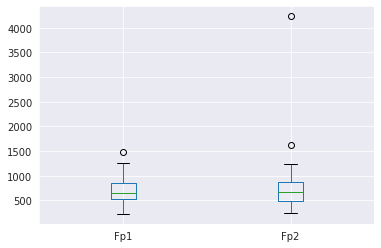

In [ ]:
df_RMSE.copy().transpose().boxplot(['Fp1', 'Fp2'])

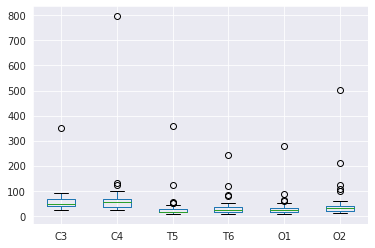

In [ ]:
df_RMSE.copy().transpose().boxplot(['C3', 'C4', 'T5', 'T6', 'O1', 'O2'])

In [ ]:
cont_denoised_SAR_subjs = {}

for idx_e_subject in range(number_subjects):
    manyCH_SAR = []
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_SAR = calculate_SAR(
            cont_EEG_e_CH=manyCH_contEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_SAR.append(oneCH_SAR)

    cont_denoised_SAR_subjs[list_denoised_EEG_keys[idx_e_subject]] = manyCH_SAR
    
# Create DataFrame for SAR
df_SAR = pd.DataFrame(data=cont_denoised_SAR_subjs, 
                      index= EEG_electrodes,
                      columns=cont_denoised_SAR_subjs.keys())

print(f"Avg. SAR of each Electrodes: \n{df_SAR.mean(axis=1)}")
print(f"Grand Avg. SAR: {np.mean(df_SAR.mean(axis=1))}")
df_SAR

Avg. SAR of each Electrodes: 
Fp1    3.263661
Fp2    3.364995
F3     4.492727
F4     4.555783
C3     6.144612
C4     6.040668
P3     7.556457
P4     7.679136
O1     7.807557
O2     8.020713
F7     5.513751
F8     5.283735
T3     6.789547
T4     6.976514
T5     7.464576
T6     7.554039
Fz     4.565028
Cz     6.114744
Pz     7.863637
dtype: float64
Grand Avg. SAR: 6.160625279376284


,sim1_con,sim2_con,sim3_con,sim4_con,sim5_con,sim6_con,sim7_con,sim8_con,sim9_con,sim10_con,sim11_con,sim12_con,sim13_con,sim14_con,sim15_con,sim16_con,sim17_con,sim18_con,sim19_con,sim20_con,sim21_con,sim22_con,sim23_con,sim24_con,sim25_con,sim26_con,sim27_con,sim28_con,sim29_con,sim30_con,sim31_con,sim32_con,sim33_con,sim34_con,sim35_con,sim36_con,sim37_con,sim38_con,sim39_con,sim40_con,sim41_con,sim42_con,sim43_con,sim44_con,sim45_con,sim46_con,sim47_con,sim48_con,sim49_con,sim50_con,sim51_con,sim52_con,sim53_con,sim54_con
Fp1,4.718553,6.557388,3.109177,5.421544,2.835435,3.645765,6.227734,1.901579,3.118042,2.569601,4.472008,2.320502,3.567781,4.478038,4.226649,2.544945,3.657566,2.342872,1.399546,3.115054,3.047730,2.393887,1.710507,3.618522,3.328663,4.274762,4.358479,4.337842,2.236471,2.583947,4.239088,5.451959,4.145180,2.361873,2.161109,3.975909,2.718159,3.611480,2.480693,2.628824,3.282482,4.325652,2.899967,2.249868,2.512007,0.947313,2.045433,2.814402,3.299026,1.914515,3.965630,2.154813,1.770753,4.160942
Fp2,4.818250,7.090237,2.857938,4.609626,2.971211,3.637987,5.765251,1.716139,3.615308,2.720726,4.009809,2.400042,3.021747,4.431115,4.039801,2.427534,3.948587,2.180119,1.698172,2.903379,4.186890,3.774102,0.679011,3.510979,5.199820,3.703809,4.253351,4.100068,3.958196,2.990095,4.567038,5.867565,3.729810,2.379999,2.226023,5.319673,3.319165,3.408511,2.651402,3.013038,2.428142,3.785008,2.713502,2.272911,3.445879,1.095122,1.318481,2.781469,3.558488,2.134455,3.965071,2.386233,1.982731,4.140719
F3,6.902084,8.198305,5.417946,5.613135,2.459212,3.962852,7.024314,4.359626,3.461655,3.881093,5.785497,2.561564,4.001976,3.881643,5.799036,6.228121,3.466015,4.500242,4.311548,5.058072,4.490934,4.812990,1.870414,4.463467,3.387181,4.022445,6.817705,7.186248,2.448470,3.209052,6.475760,6.295254,4.233759,4.300595,1.921434,2.754579,4.384284,3.309034,3.477415,4.411600,6.353631,7.565494,3.573529,6.153304,3.074468,1.987956,3.002539,4.052888,4.200617,3.862043,4.993955,3.356189,3.641518,5.642565
F4,3.434149,7.872641,4.356921,6.178666,2.854920,3.435818,7.541362,4.607997,4.167171,4.730108,4.495435,3.635246,4.582940,3.690428,5.202581,4.517518,4.205600,4.010891,4.909052,4.973541,5.246665,6.112897,0.940925,3.932856,4.225911,5.665170,6.912622,6.047033,4.988468,2.599167,6.264481,5.188008,3.301550,3.839853,3.188782,4.126636,5.976849,3.375391,3.492551,3.877014,4.604754,7.279546,3.366817,5.466293,4.840112,2.031189,4.087185,4.313043,4.500997,3.979043,5.342858,2.747304,4.649816,6.097493
C3,9.349900,9.055923,7.998743,6.381208,4.038275,5.872304,7.474330,5.684758,4.254034,4.795666,6.171638,4.917722,6.667873,5.982118,9.639994,10.635840,3.965518,5.840777,5.936582,6.552081,6.037415,5.943845,3.560166,4.870311,4.200741,5.724086,8.122809,7.277811,4.682262,5.351291,8.203985,8.083635,5.426206,4.805536,2.141244,2.679890,7.039457,6.827258,5.755574,5.272169,8.394885,9.180279,5.865120,9.320672,5.772576,4.233989,5.579341,6.171195,5.206309,5.842042,4.947117,5.249377,6.415601,6.409564
C4,9.965982,9.669516,6.986115,7.367619,3.380745,4.120917,7.433806,4.889452,4.456660,6.226787,6.004832,6.294194,6.218465,4.592018,7.295097,8.900513,3.503824,5.689781,6.904455,6.905753,6.409630,7.635055,2.543725,3.226743,5.595619,5.569832,8.348301,7.972727,4.611204,2.885433,8.721730,6.983460,5.592479,5.227720,3.743976,3.455146,7.519700,5.857348,5.600113,5.743171,5.638007,7.752165,5.181727,8.868881,6.375568,5.084370,5.957433,6.792717,5.221455,5.902637,5.870958,4.927728,5.205869,7.366924
P3,11.764270,13.774404,8.577867,7.966723,5.371896,5.678380,7.822380,6.556438,5.195504,6.642382,7.090539,3.884198,9.692521,8.313796,8.842428,11.123282,3.225237,7.156851,6.880168,6.475609,11.089435,9.296605,3.932518,5.115061,6.443156,6.887177,10.289091,10.564508,5.567342,8.234424,9.666807,9.370850,5.791764,7.240601,4.435748,3.273366,8.268433,6.984013,7.465050,7.427614,8.592002,8.173706,7.184277,10.444727,10.127766,10.281057,6.771288,8.355138,5.793515,6.849194,5.786195,7.436088,7.035159,5.840117
P4,11.848344,12.328868,9.127440,8

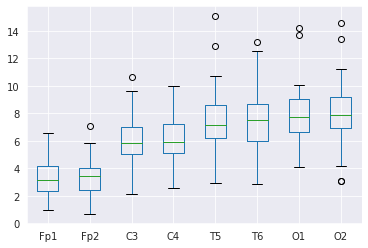

In [ ]:
df_SAR.copy().transpose().boxplot(['Fp1','Fp2','C3', 'C4', 'T5', 'T6', 'O1', 'O2'])

The shape of cont_denoised_MSC_subjs: (54, 19, 2, 101)


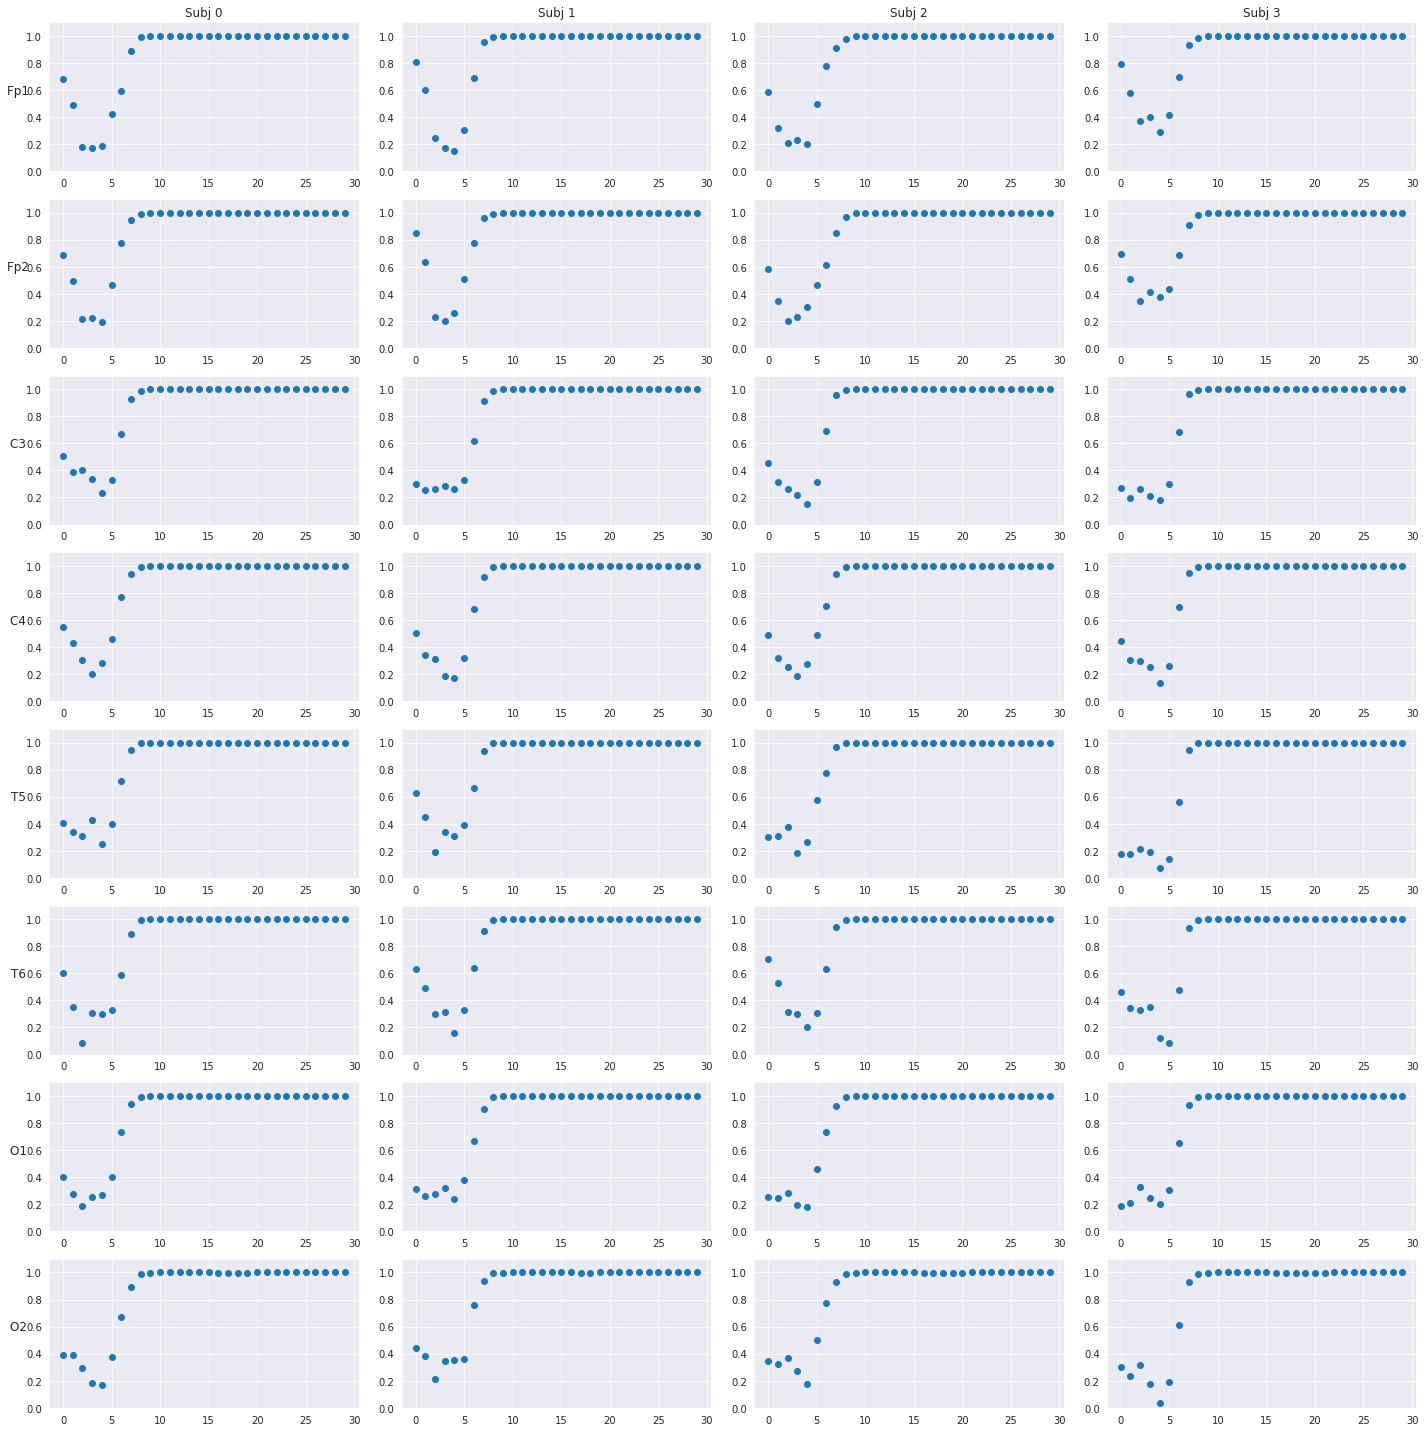

In [ ]:
cont_denoised_MSC_subjs = []

for idx_e_subject in range(number_subjects):
    manyCH_MSC = []
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_MSC = calculate_MSC(
            cont_EEG_e_CH=manyCH_contEEG[idx_channel], 
            denoised_EEG_e_CH=manyCH_denoisedEEG[idx_channel])
        
        manyCH_MSC.append(oneCH_MSC)

    cont_denoised_MSC_subjs.append(manyCH_MSC)

cont_denoised_MSC_subjs = np.array(cont_denoised_MSC_subjs)
print(f'The shape of cont_denoised_MSC_subjs: {cont_denoised_MSC_subjs.shape}')

list_selected_electrodes_indices = [EEG_electrodes.index('Fp1'), EEG_electrodes.index('Fp2'),
                                    EEG_electrodes.index('C3'), EEG_electrodes.index('C4'),
                                    EEG_electrodes.index('T5'), EEG_electrodes.index('T6'),
                                    EEG_electrodes.index('O1'), EEG_electrodes.index('O2'),]
list_selected_electrodes = ['Fp1', 'Fp2', 'C3', 'C4', 'T5', 'T6', 'O1', 'O2']


# Plot MSC
fig, axs = plt.subplots(nrows=int(len(list_selected_electrodes_indices)),
                        ncols=4, figsize=(20,20))

cols = ['Subj {}'.format(col) for col in range(4)]
rows = ['{}  '.format(row) for row in list_selected_electrodes]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
    
for idx_e_ch, e_ch in enumerate(list_selected_electrodes_indices):
    l_freq = 0
    h_freq = 30

    axs[idx_e_ch,0].scatter(
        cont_denoised_MSC_subjs[0,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[0,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,0].set_ylim(0,1.1)

    axs[idx_e_ch,1].scatter(
        cont_denoised_MSC_subjs[1,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[1,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,1].set_ylim(0,1.1)

    axs[idx_e_ch,2].scatter(
        cont_denoised_MSC_subjs[2,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[2,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,2].set_ylim(0,1.1)

    axs[idx_e_ch,3].scatter(
        cont_denoised_MSC_subjs[3,e_ch,0,l_freq:h_freq], 
        cont_denoised_MSC_subjs[3,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,3].set_ylim(0,1.1)

fig.tight_layout()
plt.show()

The shape of pure_PSD_subjs: (54, 19, 2, 101)
The shape of cont_PSD_subjs: (54, 19, 2, 101)
The shape of denoised_PSD_subjs: (54, 19, 2, 101)


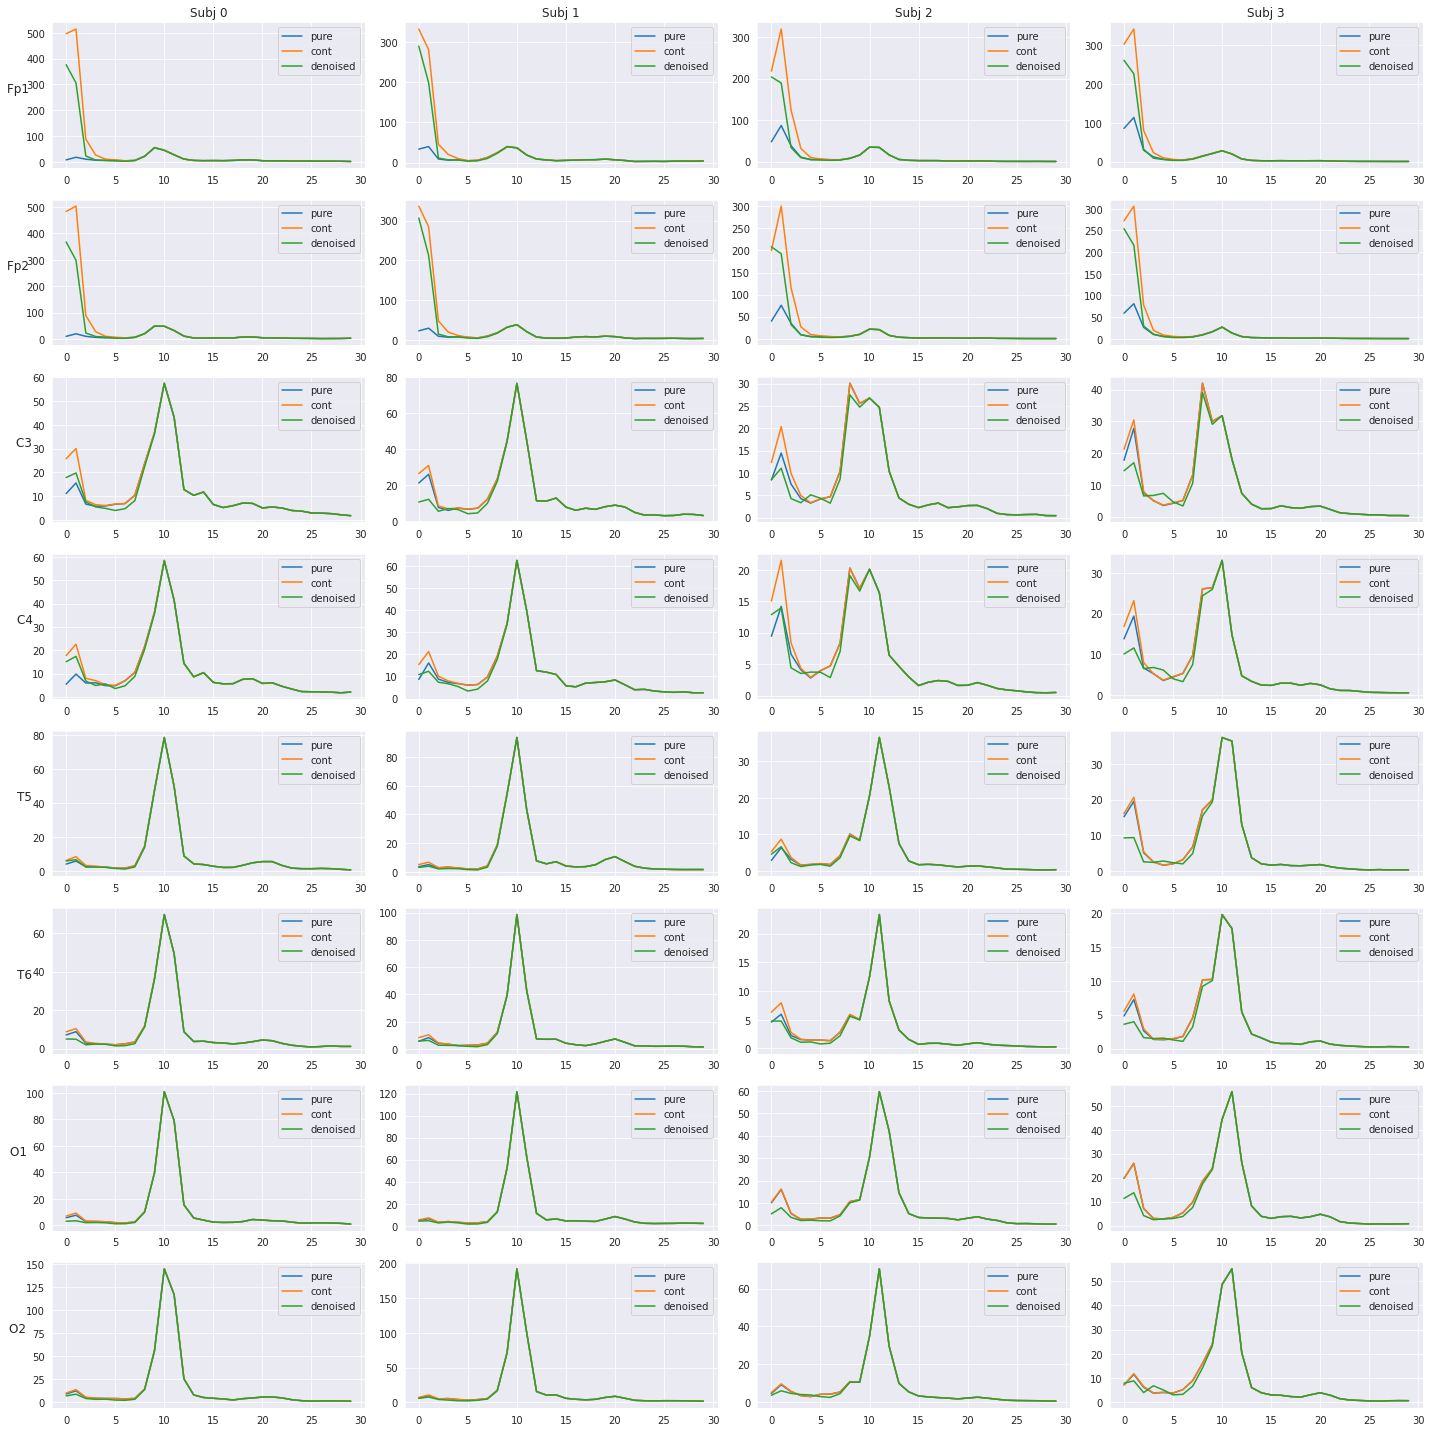

In [ ]:
pure_PSD_subjs = []
cont_PSD_subjs = []
denoised_PSD_subjs = []

for idx_e_subject in range(number_subjects):
    pure_PSD_CHs = []
    cont_PSD_CHs = []
    denoised_PSD_CHs = []

    manyCH_pureEEG = reconstructed_pure_EEG[idx_e_subject,:,:]
    manyCH_contEEG = reconstructed_cont_EEG[idx_e_subject,:,:]
    manyCH_denoisedEEG = reconstructed_denoised_EEG[idx_e_subject,:,:]
    numbers_EEG_CH = manyCH_denoisedEEG.shape[0]
    
    for idx_channel in range(numbers_EEG_CH):
        oneCH_pure_PSD = calculate_PSD(manyCH_pureEEG[idx_channel])
        oneCH_cont_PSD = calculate_PSD(manyCH_contEEG[idx_channel])
        oneCH_denoised_PSD = calculate_PSD(manyCH_denoisedEEG[idx_channel])

        pure_PSD_CHs.append(oneCH_pure_PSD)
        cont_PSD_CHs.append(oneCH_cont_PSD)
        denoised_PSD_CHs.append(oneCH_denoised_PSD)

    pure_PSD_subjs.append(pure_PSD_CHs)
    cont_PSD_subjs.append(cont_PSD_CHs)
    denoised_PSD_subjs.append(denoised_PSD_CHs)

pure_PSD_subjs = np.array(pure_PSD_subjs)
cont_PSD_subjs = np.array(cont_PSD_subjs)
denoised_PSD_subjs = np.array(denoised_PSD_subjs)

print(f'The shape of pure_PSD_subjs: {pure_PSD_subjs.shape}')
print(f'The shape of cont_PSD_subjs: {cont_PSD_subjs.shape}')
print(f'The shape of denoised_PSD_subjs: {denoised_PSD_subjs.shape}')

list_selected_electrodes_indices = [EEG_electrodes.index('Fp1'), EEG_electrodes.index('Fp2'),
                                    EEG_electrodes.index('C3'), EEG_electrodes.index('C4'),
                                    EEG_electrodes.index('T5'), EEG_electrodes.index('T6'),
                                    EEG_electrodes.index('O1'), EEG_electrodes.index('O2'),]
list_selected_electrodes = ['Fp1', 'Fp2', 'C3', 'C4', 'T5', 'T6', 'O1', 'O2']

# Plot PSD
fig, axs = plt.subplots(nrows=int(len(list_selected_electrodes_indices)),
                        ncols=4, figsize=(20,20))

cols = ['Subj {}'.format(col) for col in range(4)]
rows = ['{}  '.format(row) for row in list_selected_electrodes]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
    
for idx_e_ch, e_ch in enumerate(list_selected_electrodes_indices):
    l_freq = 0
    h_freq = 30

    axs[idx_e_ch,0].plot(
        pure_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].plot(
        cont_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].plot(
        denoised_PSD_subjs[0,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[0,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,0].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,1].plot(
        pure_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[1,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,1].plot(
        cont_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[1,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,1].plot(
        denoised_PSD_subjs[1,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[1,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,1].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,2].plot(
        pure_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[2,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,2].plot(
        cont_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[2,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,2].plot(
        denoised_PSD_subjs[2,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[2,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,2].legend(['pure', 'cont', 'denoised'])

    axs[idx_e_ch,3].plot(
        pure_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        pure_PSD_subjs[3,e_ch,1,l_freq:h_freq]
        )
    axs[idx_e_ch,3].plot(
        cont_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        cont_PSD_subjs[3,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,3].plot(
        denoised_PSD_subjs[3,e_ch,0,l_freq:h_freq], 
        denoised_PSD_subjs[3,e_ch,1,l_freq:h_freq],
        )
    axs[idx_e_ch,3].legend(['pure', 'cont', 'denoised'])

fig.tight_layout()
plt.show()

# Save metrics

In [ ]:
!pwd
df_RMSE.to_csv(path_or_buf='save_results/01_Wavelet_RMSE.csv', 
               sep=',', float_format=None)
df_SAR.to_csv(path_or_buf='save_results/01_Wavelet_SAR.csv', 
               sep=',', float_format=None)


/content/drive/My Drive/Colab Notebooks/Thesis_st121166
